In [1]:
import gym
import gym.wrappers
from gym.wrappers import RecordEpisodeStatistics
import os
from Algorithms import *
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import Health_Env
from Health_Env import *

In [2]:
env = gym.make('HealthcareEnv-v0')

In [3]:
# Hyperparameters
state_size = 3
action_size = env.action_space.n
learning_rate = 0.001
epsilon = 1.0
epsilon_decay = 0.995
final_epsilon = 0.01
gamma = 0.99
n_episodes = 1000  
batch_size = 64

In [6]:
QLagent = HealthQLearnVFA(env, learning_rate, epsilon, epsilon_decay, final_epsilon, gamma)

In [7]:
nenv = RecordEpisodeStatistics(env, deque_size=n_episodes)

In [8]:
def conv(a, win=100):
    return np.convolve(a, np.ones(win), mode='same') / win

In [9]:
budget_queue = []
for episode in tqdm(range(n_episodes)):
    observation, info = nenv.reset()
    done = False
    while not done:
        action = QLagent.policy(observation)
        s_prime, reward, terminated, truncated, info = nenv.step(action = action)
        QLagent.update(observation, action, reward, s_prime)
        done = terminated or truncated
        observation = s_prime
    QLagent.decay_epsilon()
    budget_queue.append(reward)

100%|██████████| 1000/1000 [00:36<00:00, 27.41it/s]


In [10]:
def plt_results_(env, agent_, w):
    sns.set_theme(style="whitegrid")
    rewards = conv(np.array(env.return_queue).flatten(), win=w)
    lengths = conv(np.array(env.length_queue).flatten(), win=w)
    error = conv(np.array(agent_.training_error).flatten(), win=w)

    fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
    sns.lineplot(x=range(len(rewards)), y=rewards, ax=ax[0], color='blue', linewidth=.4)
    ax[0].set_title('Reward (Average)')
    sns.lineplot(x=range(len(lengths)), y=lengths, ax=ax[1], color='blue', linewidth=.4)
    ax[1].set_title('Episode Length')
    sns.lineplot(x=range(len(error)), y=error, ax=ax[2], color='blue', linewidth=.2)
    ax[2].set_title('Error')
    for axis in ax:
        axis.tick_params(axis='x', labelsize=8)
        axis.tick_params(axis='y', labelsize=8)
    plt.tight_layout()
    plt.show()

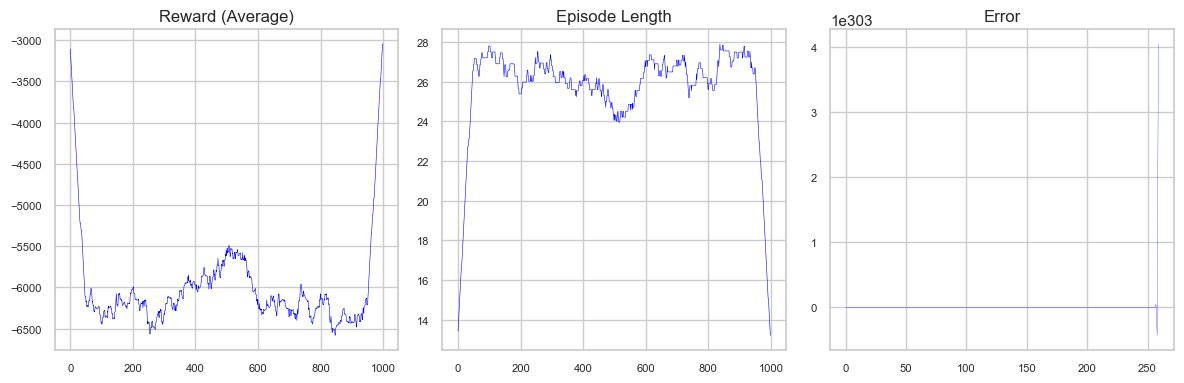

In [11]:
plt_results_(nenv, QLagent, 100)

In [20]:
action_history = []
health_level_history = []

for episode in tqdm(range(n_episodes)):
    observation, info = env.reset()
    done = False
    while not done:
        action = QLagent.policy(observation)
        s_prime, reward, terminated, truncated, info = env.step(action)
        
        # Store the action and health level for analysis
        action_history.append(action)
        health_level_history.append(observation["health_level"])  # Append current health level
        
        QLagent.update(observation, action, reward, s_prime)
        done = terminated or truncated
        observation = s_prime
    QLagent.decay_epsilon()

100%|██████████| 1000/1000 [00:41<00:00, 24.09it/s]


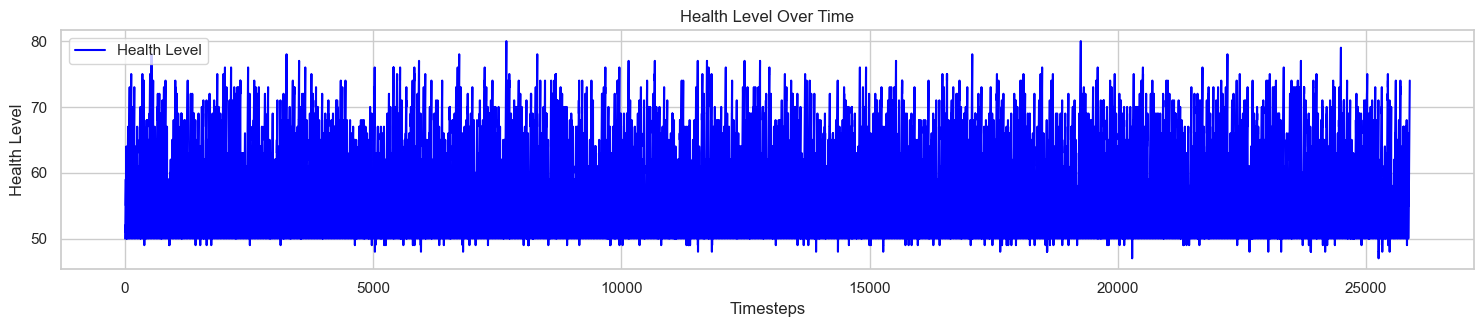

In [21]:
plt.figure(figsize=(15, 6))

# Plotting the health levels
plt.subplot(2, 1, 1)
plt.plot(health_level_history, label='Health Level', color='blue')
plt.title('Health Level Over Time')
plt.xlabel('Timesteps')
plt.ylabel('Health Level')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
state_size = len(env.observation_space.spaces) 
action_size = env.action_space.n

In [ ]:
DQL_agent = HealthcareDQL(
    environment=env,
    state_size=state_size,
    action_size=action_size,
    learning_rate=learning_rate,
    gamma=gamma,
    epsilon=epsilon,
    final_epsilon=final_epsilon,
    epsilon_decay=epsilon_decay
)

In [24]:
state, info = env.reset()

# Lists to store the history of budget, health level, and risk level
budget_history = []
health_level_history = []
risk_level_history = []

for _ in range(100):
    # Get the current state as a numpy array
    state_array = np.array([state['budget'][0], state['health_level'], state['risk_level']])
    action = DQL_agent.act(state_array)

    # Take a step in the environment
    s_prime, reward, terminated, truncated, info = env.step(action=action)

    # Append the current state values to the history lists
    budget_history.append(state['budget'][0])
    health_level_history.append(state['health_level'])
    risk_level_history.append(state['risk_level'])
    print(f'Timestep: {_}, Action: {action}, Budget: {state["budget"][0]}, Health Level: {state["health_level"]}, Risk Level: {state["risk_level"]}')

    if terminated or truncated:
        print(f'Final state: {s_prime}')
        print("End of simulation")
        state, info = env.reset()
        break
    else:
        state = s_prime

env.close()

Timestep: 0, Action: 2, Budget: 1000.0, Health Level: 50, Risk Level: 50
Timestep: 1, Action: 2, Budget: 1002.0, Health Level: 50, Risk Level: 50
Timestep: 2, Action: 0, Budget: 1004.0, Health Level: 50, Risk Level: 50
Timestep: 3, Action: 2, Budget: 1002.0, Health Level: 53, Risk Level: 47
Timestep: 4, Action: 1, Budget: 1004.0, Health Level: 51, Risk Level: 49
Timestep: 5, Action: 1, Budget: 1003.0, Health Level: 52, Risk Level: 48
Timestep: 6, Action: 2, Budget: 1002.0, Health Level: 53, Risk Level: 47
Timestep: 7, Action: 1, Budget: 1004.0, Health Level: 53, Risk Level: 47
Timestep: 8, Action: 2, Budget: 1003.0, Health Level: 54, Risk Level: 46
Timestep: 9, Action: 2, Budget: 1005.0, Health Level: 54, Risk Level: 46
Timestep: 10, Action: 2, Budget: 1007.0, Health Level: 54, Risk Level: 46
Timestep: 11, Action: 1, Budget: 1009.0, Health Level: 54, Risk Level: 46
Timestep: 12, Action: 2, Budget: 1008.0, Health Level: 55, Risk Level: 45
Timestep: 13, Action: 0, Budget: 1010.0, Health 

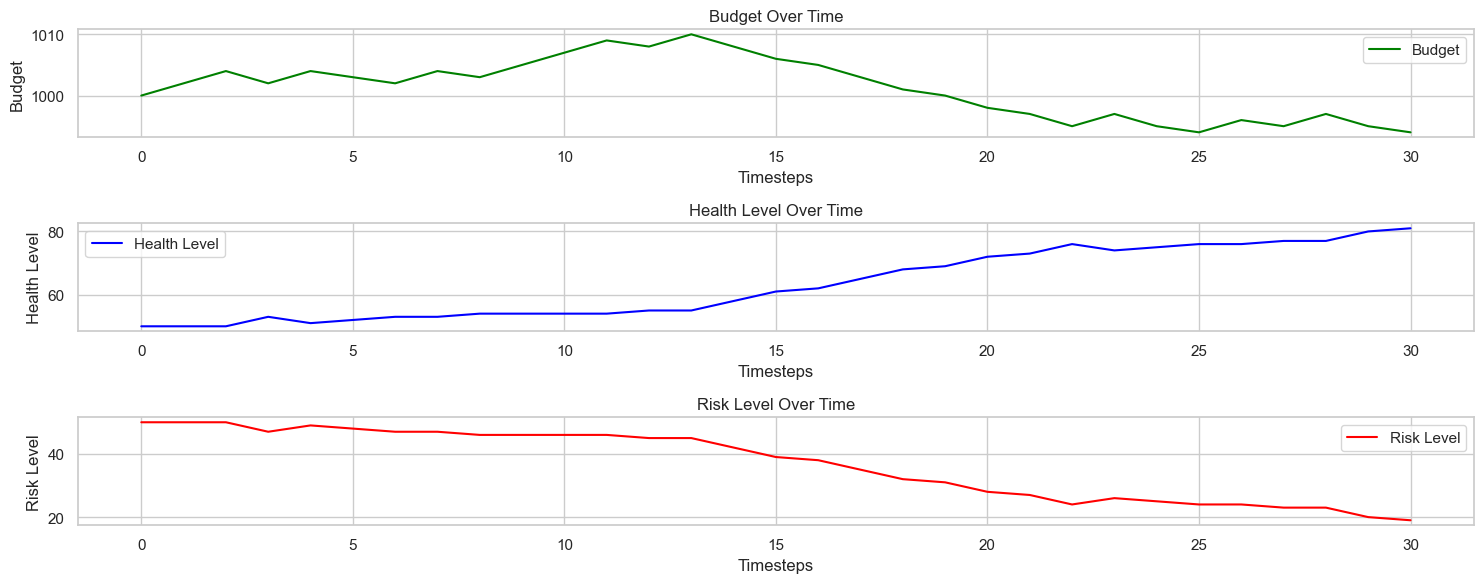

In [25]:
plt.figure(figsize=(15, 6))

# Budget Plot
plt.subplot(3, 1, 1)
plt.plot(budget_history, label='Budget', color='green')
plt.title('Budget Over Time')
plt.xlabel('Timesteps')
plt.ylabel('Budget')
plt.legend()

# Health Level Plot
plt.subplot(3, 1, 2)
plt.plot(health_level_history, label='Health Level', color='blue')
plt.title('Health Level Over Time')
plt.xlabel('Timesteps')
plt.ylabel('Health Level')
plt.legend()

# Risk Level Plot
plt.subplot(3, 1, 3)
plt.plot(risk_level_history, label='Risk Level', color='red')
plt.title('Risk Level Over Time')
plt.xlabel('Timesteps')
plt.ylabel('Risk Level')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
healthcare_levels = []
risk_levels = []
years = []

episodes = 1000
for episode in range(episodes):
    state, info = env.reset()
    timestep = 0

    while True:
        state_array = np.array([state['budget'][0], state['health_level'], state['risk_level']])
        action = DQL_agent.act(state_array)
        s_prime, reward, terminated, truncated, info = env.step(action=action)
        if timestep % 5 == 0:
            healthcare_levels.append(s_prime['health_level'])
            risk_levels.append(s_prime['risk_level'])
            years.append(env.current_year) 
        print(f'Timestep: {episode}, Action: {action}, Budget: {state["budget"][0]}, Health Level: {state["health_level"]}, Risk Level: {state["risk_level"]}')
        timestep += 1

        if terminated or truncated:
            print(f'Final state: {s_prime}')
            print("End of simulation")
            state, info = env.reset()
            break
        else:
            state = s_prime

env.close()

In [41]:
def generate_trajectories(env, agent, num_trajectories=50000, trajectory_length=30):
    healthcare_levels = []
    risk_levels = []
    years = []

    for trajectory in tqdm(range(num_trajectories)):
        state, info = env.reset()
        for timestep in range(trajectory_length):
            # Store healthcare and risk levels
            healthcare_levels.append(state['health_level'])
            risk_levels.append(state['risk_level'])
            years.append(env.current_year) 
            
            action = agent.act(state)
            s_prime, reward, terminated, truncated, info = env.step(action)
            
            if terminated or truncated:
                break
            else:
                state = s_prime

    return years, healthcare_levels, risk_levels

In [42]:
years, healthcare_levels, risk_levels = generate_trajectories(env, DQL_agent)

100%|██████████| 50000/50000 [00:36<00:00, 1385.73it/s]


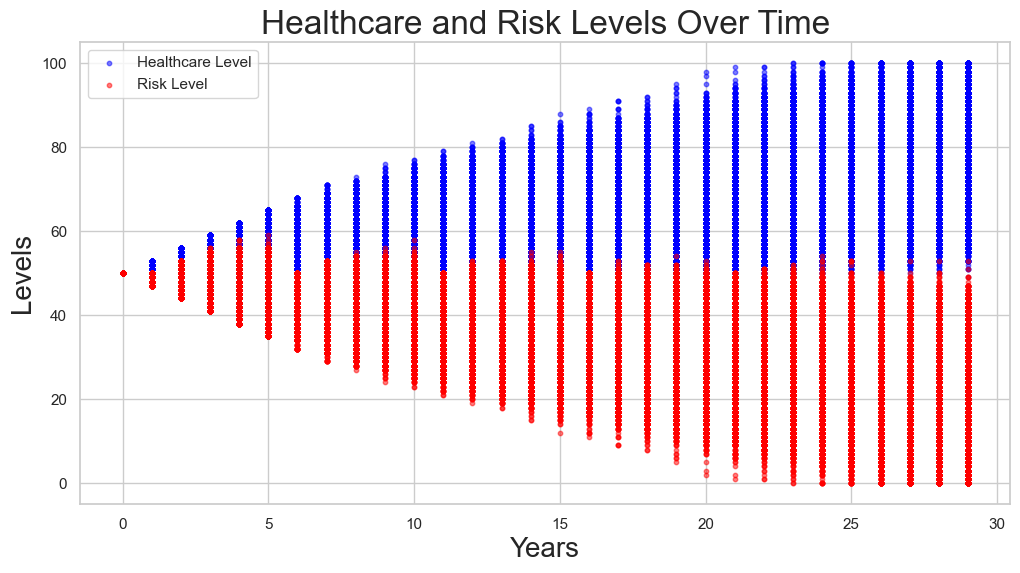

In [44]:
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
plt.scatter(years, healthcare_levels, alpha=0.5, color='blue', label='Healthcare Level', s=10)
plt.scatter(years, risk_levels, alpha=0.5, color='red', label='Risk Level', s=10)
plt.title('Healthcare and Risk Levels Over Time', size=24)
plt.xlabel('Years', size=20)
plt.ylabel('Levels', size=20)
plt.legend()
plt.show()